In [15]:
import numpy as np
from scipy.fft import fft, ifft, fftshift
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pickle
from copy import copy

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [16]:
with open('data_set_2.pkl', 'rb') as f:
    data_set_2 = pickle.load(f)

xvals1 = data_set_2[:, 0]
yvals1 = data_set_2[:, 1]  + 2. + 3.*xvals1**2.

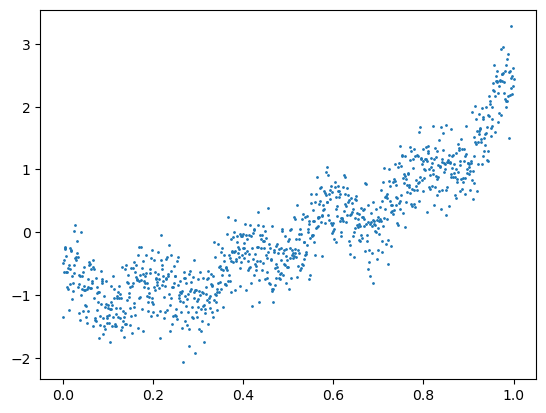

In [17]:
# rescale data
xmax = np.max(xvals1)
ymean = np.mean(yvals1)
ystd = np.std(yvals1)
xvalsrsc = xvals1/xmax
yvalsrsc = (yvals1-ymean)/ystd
plt.scatter(xvalsrsc, yvalsrsc, s=1.)

In [18]:
freqdata = np.abs(np.fft.fft(yvalsrsc))
# something you could play with here

In [19]:
def xp_mat_maker(xvals, p, ovals):
    xp = np.ones((xvals.size, p + 1 + 2*ovals.size))
    for jj in range(p):
        xp[:, jj+1] = xvals * xp[:, jj]
    for jj in range(ovals.size):
        xp[:, jj+p+1] = np.cos(ovals[jj]*xvals)
        xp[:, jj+1+p+1] = np.sin(ovals[jj]*xvals)
    return xp

In [20]:
def least_squares_solve(mat, yvals):
    u, s, vt = np.linalg.svd(mat, full_matrices=False)
    alpha = (vt.T @ np.diag(1./s) @ u.T) @ yvals.reshape(-1, 1)
    error = np.linalg.norm(mat @ alpha - yvals.reshape(-1, 1))**2./(2.*yvals.size)
    return alpha, error 

In [66]:
def cross_fold(alpha, xvals, yvals, pval, ovals, kfolds):

    kf = KFold(n_splits=kfolds)
    w_avg = np.zeros(pval+1+2*ovals.size)
    errors = np.zeros(kfolds)
    cnt = 0

    for train, test in kf.split(xvals):
        xtrain, ytrain = xvals[train], yvals[train]
        xtest, ytest = xvals[test], yvals[test]
        xp_train = xp_mat_maker(xtrain, pval, ovals)        
        res = Lasso(alpha, max_iter=16000, tol=1e-4).fit(xp_train, ytrain) # alpha > 0
        w_lasso = res.coef_
        w_avg += w_lasso
        
        xp_test = xp_mat_maker(xtest, pval, ovals)
        errors[cnt] = np.linalg.norm(xp_test @ w_lasso.reshape(-1,1) - ytest)/np.sqrt(2.*ytest.size)
        cnt += 1
        
    error = np.mean(errors)
    var = np.std(errors)
    return w_avg/kfolds, error, var

**Problem 1**: To get a feel for how LASSO regression works, we will study the problem of solving 
$$
A{\bf x} = {\bf b}, ~ A \in \mathbb{R}^{n\times m}, {\bf b} \in \mathbb{R}^{n}
$$
via least squares with and without LASSO.  Thus we study minimizing the objective function $f({\bf x})$ where 
$$
f({\bf x}) = \frac{1}{2n}\left|\left|{\bf b} - A{\bf x}\right|\right|^{2}_{2} + \alpha \left|\left|{\bf x}\right|\right|_{1}, ~ \alpha \geq 0.
$$

We choose $A$ and ${\bf b}$ at random from Gaussian distributions of zero mean and variance $\sigma$.  By varying $n$, $m$, and $\sigma$, generate distributions of the values of ${\bf x}$ for $\alpha=10^{-4}$, $10^{-3}$, $10^{-2}$.  Characterize the impact of LASSO on the spread in the values of ${\bf x}$.  Also, generate affiliated distributions of the error in your fits.  Describe any differences you see between LASSO fits and fits done with classic least-squares.  

In [67]:
def lasso_model_testing(num_experiments, nmodel, nmeasure, varsq, aval):
    lasso_vals = np.zeros(num_experiments*nmodel)
    lstsqs_vals = np.zeros(num_experiments*nmodel)
    for jj in range(num_experiments):
        Amat = varsq*np.random.randn(nmeasure, nmodel)
        bvec = varsq*np.random.randn(nmeasure)
        res = Lasso(alpha=aval).fit(Amat, bvec.reshape(-1, 1)) # alpha > 0
        alpha_lasso = res.coef_
        alpha, error = least_squares_solve(Amat, bvec) # i.e. alpha = 0, or no LASSO
        lasso_vals[jj*nmodel:(jj+1)*nmodel] = alpha_lasso
        lstsqs_vals[jj*nmodel:(jj+1)*nmodel] = np.squeeze(alpha)
    return lasso_vals, lstsqs_vals

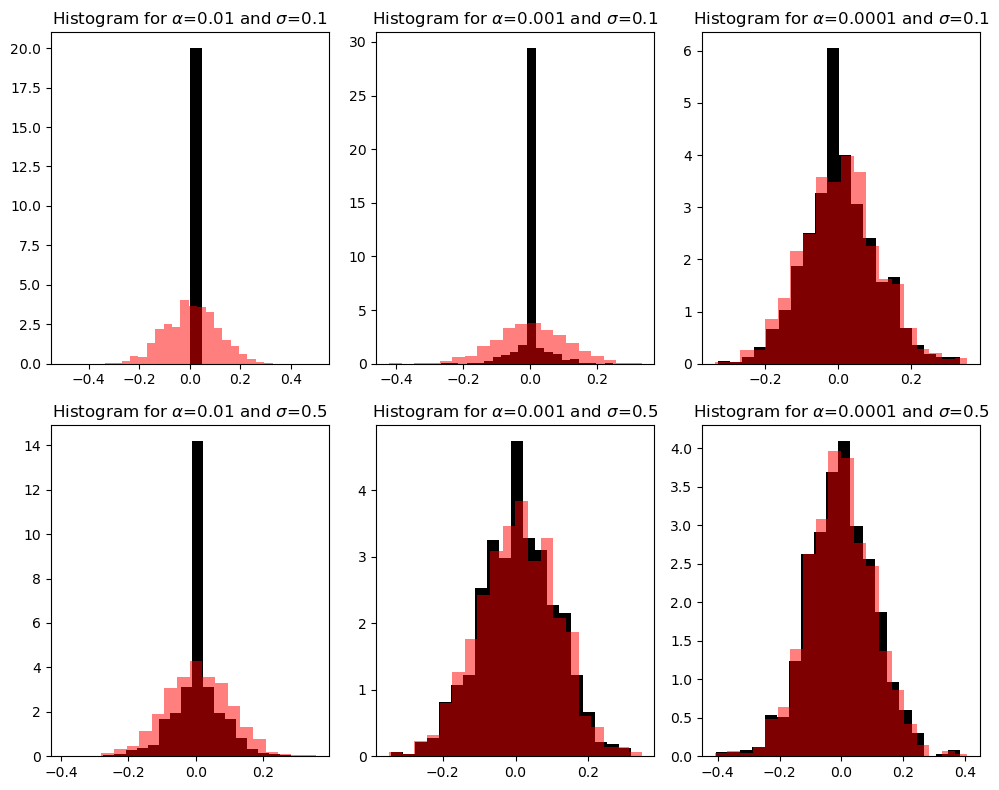

In [68]:
nmodel = 10
nmeasure = 100
num_experiments = 100 

varsqs = [.1, .5]
avals = [1e-2, 1e-3, 1e-4]

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
ax = axes.ravel()
cnt = 0

for varsq in varsqs:
    for aval in avals:

        res = lasso_model_testing(num_experiments, nmodel, nmeasure, varsq, aval)
        ax[cnt].hist(res[0], density=True, bins=20, color='k')
        ax[cnt].hist(res[1], density=True, bins=20, color='r', alpha=.5)
        ax[cnt].set_title(fr"Histogram for $\alpha$={aval} and $\sigma$={varsq}")
        cnt+=1

plt.tight_layout()

**Problem 2**: Now, using the `xvals1, yvals1` data set, suppose we build a general model of the form 
$$
y(x) = \sum_{l=0}^{p}\alpha_{l}x^{l} + \sum_{j=1}^{m}\left(\beta_{j}\cos(\omega_{j}x)+\gamma_{j}\sin(\omega_{j}x)\right)
$$

* Choose some $p$, $m$, and corresponding range of frequences $\omega_{j}$.  Note, the point of LASSO is to be able to build general models and let the optimization tell you what to keep, so this is supposed to be relatively broad.  

* Using the 10-fold split as in lecture, repeat the analysis in the lecture notes but now for this more complex model.  Comment on the quality of LASSO in finding good fits while also making meaningful parameter selections.  

* What do you think the polynomial part of the data is?  What about the trigonometric part?  What does your best fit look like in comparison to the data?   

In [85]:
numlams = 30
lampows = np.linspace(-5, 0., numlams) # this could be changed depending on you make other decisions
errors = np.zeros(lampows.size)
stds = np.zeros(lampows.size)
pval = 10
ovals = 2.*np.pi*np.arange(1, 5)
kfolds = 10
avalsvslam = np.zeros((pval+1+2*ovals.size, numlams))

for jj, lampow in enumerate(lampows):
    lam = 10**(lampow)    
    w_avg, mean, std = cross_fold(lam, xvalsrsc, yvalsrsc, pval, ovals, kfolds)
    avalsvslam[:, jj] = w_avg
    errors[jj] = mean
    stds[jj] = std

Text(0, 0.5, 'Mean Error')

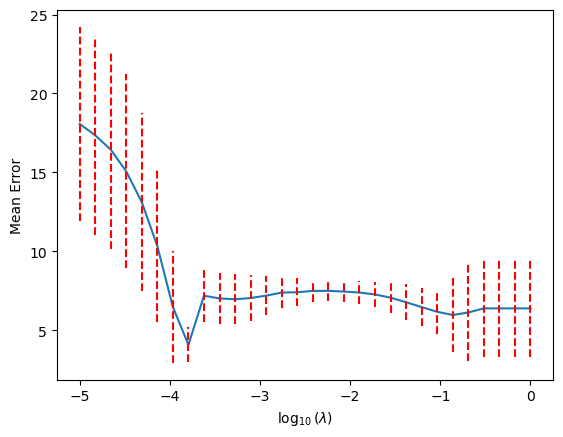

In [86]:
plt.plot(lampows, errors) # how would you plot the standard devations as error bars around the mean of the error?
for jj in range(stds.size):
    ejp = errors[jj] + stds[jj]
    ejm = errors[jj] - stds[jj]
    plt.plot([lampows[jj], lampows[jj]], [ejm, ejp], ls='--', c='r')
plt.xlabel(r"$\log_{10}(\lambda)$");
plt.ylabel(r"Mean Error")

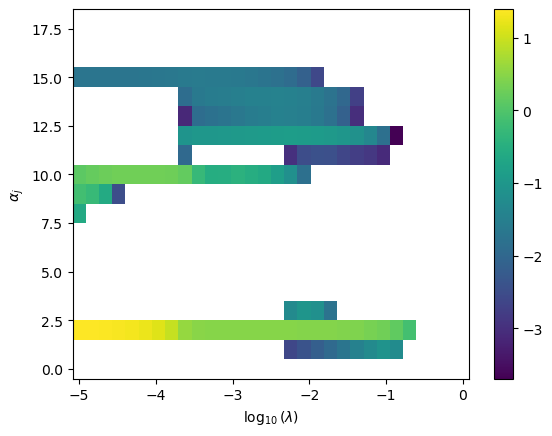

In [87]:
cfig = plt.pcolormesh(lampows, np.arange(pval+1+2*ovals.size), np.ma.log10(avalsvslam))
plt.xlabel(r"$\log_{10}(\lambda)$")
plt.ylabel(r"$\alpha_{j}$")
plt.colorbar(cfig);

[ 0.         -4.77192762  8.8049445   0.          0.         -2.23632441
 -0.37404832  0.          0.          0.        ]
[ 1.86837991 -0.41883515 -0.02916598 -0.05510375 -0.02088167  0.02209895
  0.          0.          0.        ]


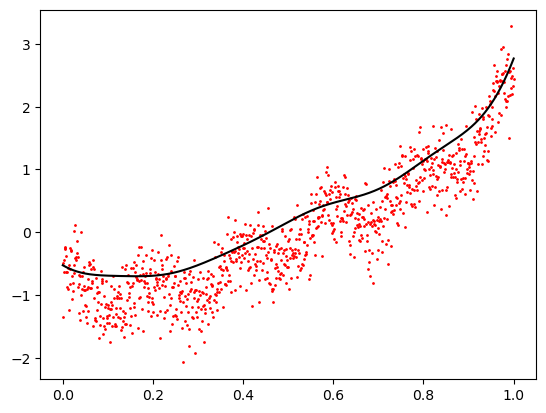

In [88]:
# Find alpha model corresponding to the lowest error

ind_min = np.argmin(errors)
fit = xp_mat_maker(xvalsrsc, pval, ovals) @ avalsvslam[:, ind_min].reshape(-1, 1)

plt.plot(xvalsrsc, fit, c='k')
plt.scatter(xvalsrsc, yvalsrsc, c='r', s=1.)

poly_terms = avalsvslam[:pval, ind_min]
print(poly_terms)
trig_terms = avalsvslam[pval:, ind_min]
print(trig_terms)

**Problem 3** (Graduate): Since there was so much interest in this problem, I'll have y'all work it out.  So, suppose that, for ${\bf y}, {\bf z} \in \mathbb{R}^{n}$ we want to solve 

$$
{\bf z}_{\ast} = \text{arg min}_{{\bf z}} ~ \left|\left|{\bf y} - A{\bf z}\right|\right|_{2}^{2} + \lambda \left|\left|{\bf z}\right|\right|_{1} + \gamma \left|\left|{\bf z}\right|\right|_{2}^{2}
$$

where $\lambda, ~ \gamma > 0$ and for real-valued, square $A$ such that $A^{T}A = AA^{T} = I$.  Letting ${\bf u} = A^{T}{\bf y}$, show that 

$$
z_{\ast,l} = \left\{
\begin{array}{rl}
\frac{1}{1+\gamma}\left(u_{l} - \frac{\lambda}{2}\right) & u_{l} > \frac{\lambda}{2} \\
0 & |u_{l}| \leq \frac{\lambda}{2} \\ 
\frac{1}{1+\gamma}\left(u_{l} + \frac{\lambda}{2}\right) & u_{l} < -\frac{\lambda}{2} 
\end{array}
\right.
$$

Show that this multi-part formula can be written in the freakishly compact form

$$
z_{\ast,l} = \frac{u_{l}}{1+\gamma}\text{max}\left\{0, 1 - \frac{\lambda}{2|u_{l}|}\right\}
$$

Note, to do all of this, you'll need the sub-differential of $|x|$, $\partial |x|$, where 

$$
\partial |x| = \left\{
\begin{array}{rl}
1 & x > 0\\
r\in(-1,1)& x=0, ~ \\
-1 & x < 0
\end{array}
\right.
$$

**Problem 4**: (Graduate) Show that for a differentiable convex function, say $f({\bf x})$ with gradient $\nabla f$, that for all ${\bf y}$ and ${\bf x}$ in $E$ that
$$
f({\bf y}) - f({\bf x}) \geq \left<\nabla_{{\bf x}}f, {\bf y}-{\bf x}\right>
$$

From this, show that a local minimum of a convex function is necessarily a global one.  To get the first result, swap the positions of ${\bf x}$ and ${\bf y}$ in the above definition of a convex function.  Then figure out how to get things in terms of difference quotients and then take a limit in $\lambda$.